In [55]:
import numpy as np
import statsmodels.api as sm
import scipy as sp
import scipy.special
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# sigmoid function
def sigmoid(x):
    return (1/(1 + np.exp(-x)))

# weight dot independent variables 
def pro(w, x):
    return sigmoid(np.inner(w, x))

# first coefficient in beta prior
def alpha(p, phi):
    return (((1 / phi) - 1) * p)

# second coefficient in beta prior
def beta(p, phi):
    return (((1 / phi) - 1) * (1 - p))

# average cost of beta-binomial regression excluding constant 
def cost(f, exog, endog):
    cos = 0
    for n in range(len(exog)):
        p = pro(f[:-1], exog[n])
        a = alpha(p, f[-1])
        b = beta(p, f[-1])
        cos += sp.special.betaln(endog[n][0] + a, endog[n][1] + b) - sp.special.betaln(a, b)
    return - cos / len(exog)

# predict the output given the parametres
def predict(f, exog, endog):
    p_pred = sigmoid(np.matmul(exog, f[:-1]))
    return np.concatenate(([p_pred * (endog[:, 0] + endog[:, 1])], [(1 - p_pred) * (endog[:, 0] + endog[:, 1])]), axis = 0).T 

# log-likelihood of the data
def LL(f, exog, endog):
    return - cost(f, exog, endog) * len(exog) + sum(sp.special.gammaln(endog[:,0] + endog[:,1] + 1) - sp.special.gammaln(endog[:,0] + 1) - sp.special.gammaln(endog[:,1] + 1))

# find the best initial guess for phi
def initial(params, exog, endog):
    guess = np.arange(0.99999, 10, 0.1)
    cos = [0]
    while np.argmin(cos) == 0:
        guess = guess / 10
        cos = []
        for m in range(len(guess)): 
            f = np.concatenate((params, [guess[m]]))
            cos.append(cost(f, exog, endog))
    f = np.concatenate((params, [guess[np.argmin(cos)]]))
    # print("initial guess = ", f)
    # print("cost of initial guess =", cos[np.argmin(cos)])
    return f

# beta-binomial regression
def fit(self):
    glm_binom = sm.GLM(self.endog, self.exog, family = sm.families.Binomial())
    res = glm_binom.fit()
        
    bnds = []
    for m in range(len(res.params)):
        bnds.append((- np.inf, np.inf))
    bnds.append((0,1))
    bnds_t = tuple(bnds)
        
    f = initial(res.params, self.exog, self.endog)
    ress = sp.optimize.minimize(cost, f, args = (self.exog, self.endog), method = self.method, bounds = bnds_t)
    return ress.x

In [57]:
# can be any method scipy.optimize.minimize supports
class betabin:
    def __init__(self, exog, endog, fit_intercept = True, method = "SLSQP"):
        self.n_features_in_ = len(exog[0])
        self.intercept_ = fit_intercept
        if self.intercept_:
            exog = sm.add_constant(exog, prepend = False)
        self.exog = exog
        self.endog = endog
        self.method = method
        self.params = fit(self)
        self.predict = predict(self.params, self.exog, self.endog)
        self.LL = LL(self.params, self.exog, self.endog)
        # if self.LL > 0:
        #     raise Exception("Abnormal log-likelihood")

In [58]:
AD = sp.io.mmread("AD.mtx")
DP = sp.io.mmread("DP.mtx")

AD1 = np.asarray(AD.todense())
DP1 = np.asarray(DP.todense())

label = pd.read_csv('id.csv')
label1 = label.iloc[:,1].to_numpy()

clone0 = np.zeros(77) 
clone0[np.where(label1 == 0)] = 1
clone1 = np.zeros(77) 
clone1[np.where(label1 == 1)] = 1
clone2 = np.zeros(77) 
clone2[np.where(label1 == 2)] = 1

In [59]:
summ = []
for n in range(24):
    summ.append(np.sum(DP1[n]))
summ

[11583.0,
 11180.0,
 6338.0,
 12802.0,
 2288.0,
 7882.0,
 30690.0,
 34664.0,
 14843.0,
 31001.0,
 14305.0,
 1648.0,
 16366.0,
 5046.0,
 22379.0,
 13710.0,
 32388.0,
 10237.0,
 24403.0,
 1346.0,
 8812.0,
 1175.0,
 1200.0,
 1178.0]

In [60]:
print("clone 0:", len(np.where(label1 == 0)[0]))
print("clone 1:",len(np.where(label1 == 1)[0]))
print("clone 2:",len(np.where(label1 == 2)[0]))

clone 0: 15
clone 1: 55
clone 2: 7


In [61]:
# all clones
all_LL = []
for SNP in range(24):
    mask = np.where(DP1[SNP] != 0)
    endog = np.array([AD1[SNP][mask], DP1[SNP][mask] - AD1[SNP][mask]]).T
    exog = np.array([clone1[mask], clone2[mask]]).T
    model = betabin(exog, endog)
    all_LL.append(model.LL)
print(max(all_LL))
print(min(all_LL))
all_LL = np.array(all_LL)

/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


-19.960532314292216
-343.31176367855187


In [62]:
# clone 0 only
clone0_LL = []
for SNP in range(24):
    mask = np.where(DP1[SNP] != 0)
    endog = np.array([AD1[SNP][mask], DP1[SNP][mask] - AD1[SNP][mask]]).T
    exog = np.array([clone0[mask]]).T
    model = betabin(exog, endog)
    clone0_LL.append(model.LL)
print(max(clone0_LL))
print(min(clone0_LL))
clone0_LL = np.array(clone0_LL)

/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


-20.181521410577638
-344.1839458401173


In [63]:
# clone 1 only
clone1_LL = []
for SNP in range(24):
    mask = np.where(DP1[SNP] != 0)
    endog = np.array([AD1[SNP][mask], DP1[SNP][mask] - AD1[SNP][mask]]).T
    exog = np.array([clone1[mask]]).T
    model = betabin(exog, endog)
    clone1_LL.append(model.LL)
print(max(clone1_LL))
print(min(clone1_LL))
clone1_LL = np.array(clone1_LL)

/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


-20.156799230187374
-343.3180794992113


In [64]:
# clone 2 only
# abnormal log-likelihood on one SNP, should be a bug in the log-likelihood function
clone2_LL = []
for SNP in range(24):
    mask = np.where(DP1[SNP] != 0)
    endog = np.array([AD1[SNP][mask], DP1[SNP][mask] - AD1[SNP][mask]]).T
    exog = np.array([clone2[mask]]).T
    model = betabin(exog, endog)
    clone2_LL.append(model.LL)
print(max(clone2_LL))
print(min(clone2_LL))
clone2_LL = np.array(clone2_LL)

/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


-19.962060102618928
-345.1818253074907


In [65]:
# no clones
nil_LL = []
for SNP in range(24):
    mask = np.where(DP1[SNP] != 0)
    endog = np.array([AD1[SNP][mask], DP1[SNP][mask] - AD1[SNP][mask]]).T
    exog = np.array([np.ones(len(mask[0]))]).T
    model = betabin(exog, endog, fit_intercept = False)
    nil_LL.append(model.LL)
print(max(nil_LL))
print(min(nil_LL))
nil_LL = np.array(nil_LL)
nil_LL

/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * p)
/var/folders/gq/3xlzgly13xz5t2q4ffg3497r0000gn/T/ipykernel_43057/2026911291.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return (((1 / phi) - 1) * (1 - p))


-20.18205917612425
-345.6647039381587


array([-105.9298292 ,  -72.41462702,  -68.79230114,  -45.65327614,
        -41.89914794,  -43.33996837, -119.68139028,  -52.91843891,
       -345.66470394,  -78.63594518,  -88.86357681,  -20.18205918,
        -44.27214777,  -29.01872211,  -38.3072852 , -117.267482  ,
        -80.56271148,  -59.97284417, -229.50104198, -179.86044782,
        -79.18667787, -139.91199658, -147.16935947, -143.72186357])

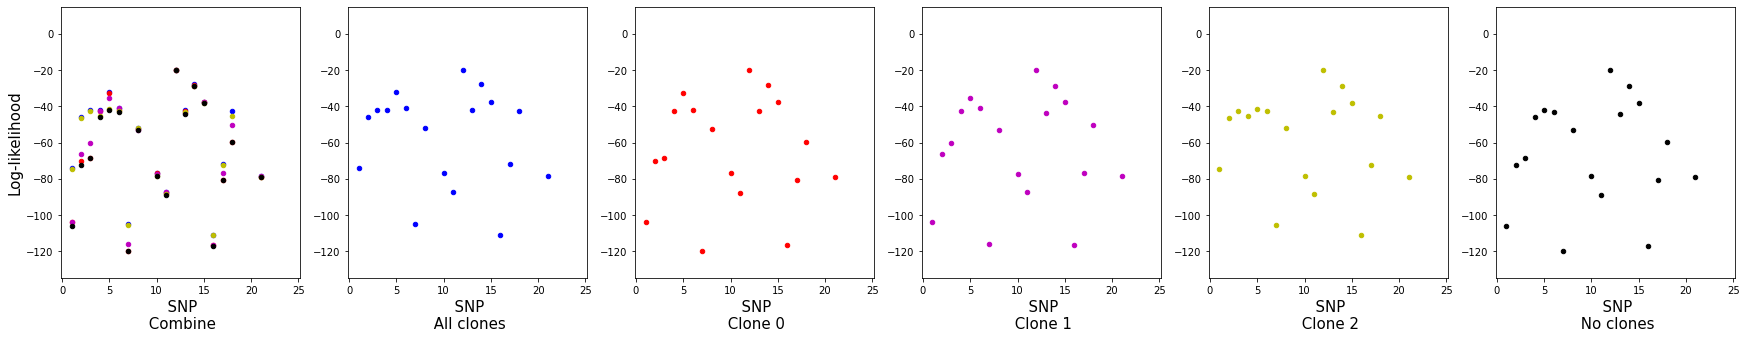

In [66]:
SNPS = np.arange(1, 25, dtype = int)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
ax1.set_xlabel("  SNP \n Combine", fontsize = 15)
ax1.set_ylabel("Log-likelihood", fontsize = 15)
ax2.set_xlabel("  SNP \n All clones", fontsize = 15)
ax3.set_xlabel("  SNP \n Clone 0", fontsize = 15)
ax4.set_xlabel("  SNP \n Clone 1", fontsize = 15)
ax5.set_xlabel("  SNP \n Clone 2", fontsize = 15)
ax6.set_xlabel("  SNP \n No clones", fontsize = 15)
ax1.scatter(SNPS, all_LL, s = 20, c ='b')
ax1.scatter(SNPS, clone0_LL, s = 20, c ='r')
ax1.scatter(SNPS, clone1_LL, s = 20, c ='m')
ax1.scatter(SNPS, clone2_LL, s = 20, c ='y')
ax1.scatter(SNPS, nil_LL, s = 20, c ='k')
ax2.scatter(SNPS, all_LL, s = 20, c ='b')
ax3.scatter(SNPS, clone0_LL, s = 20, c ='r')
ax4.scatter(SNPS, clone1_LL, s = 20, c ='m')
ax5.scatter(SNPS, clone2_LL, s = 20, c ='y')
ax6.scatter(SNPS, nil_LL, s = 20, c ='k')
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax1.get_xlim())
ax6.set_xlim(ax1.get_xlim())
ax1.set_ylim((-135, 15))
ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())
ax4.set_ylim(ax1.get_ylim())
ax5.set_ylim(ax1.get_ylim())
ax6.set_ylim(ax1.get_ylim())
plt.show()

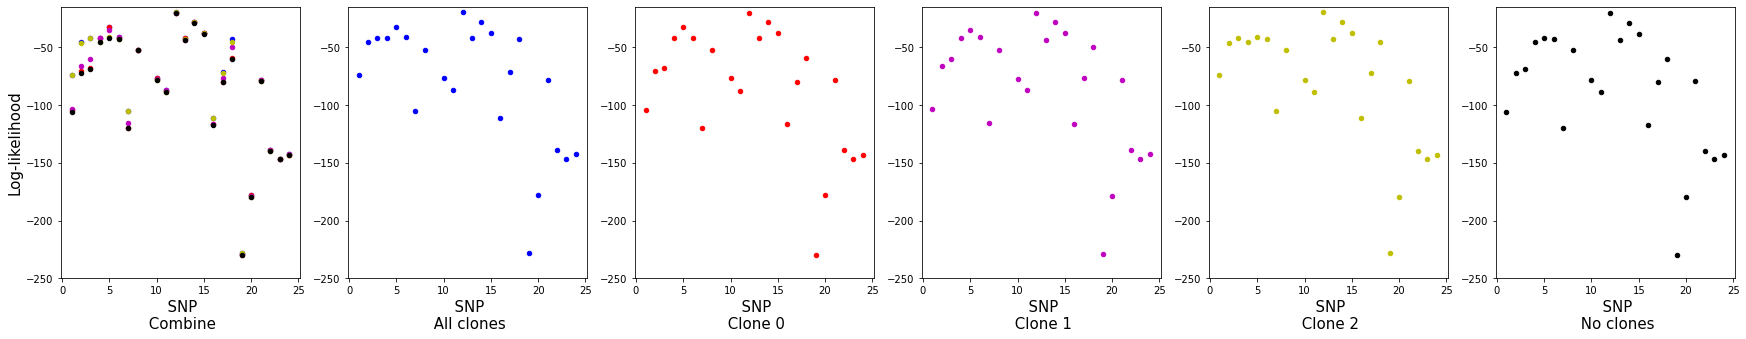

In [67]:
SNPS = np.arange(1, 25, dtype = int)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
ax1.set_xlabel("  SNP \n Combine", fontsize = 15)
ax1.set_ylabel("Log-likelihood", fontsize = 15)
ax2.set_xlabel("  SNP \n All clones", fontsize = 15)
ax3.set_xlabel("  SNP \n Clone 0", fontsize = 15)
ax4.set_xlabel("  SNP \n Clone 1", fontsize = 15)
ax5.set_xlabel("  SNP \n Clone 2", fontsize = 15)
ax6.set_xlabel("  SNP \n No clones", fontsize = 15)
ax1.scatter(SNPS, all_LL, s = 20, c ='b')
ax1.scatter(SNPS, clone0_LL, s = 20, c ='r')
ax1.scatter(SNPS, clone1_LL, s = 20, c ='m')
ax1.scatter(SNPS, clone2_LL, s = 20, c ='y')
ax1.scatter(SNPS, nil_LL, s = 20, c ='k')
ax2.scatter(SNPS, all_LL, s = 20, c ='b')
ax3.scatter(SNPS, clone0_LL, s = 20, c ='r')
ax4.scatter(SNPS, clone1_LL, s = 20, c ='m')
ax5.scatter(SNPS, clone2_LL, s = 20, c ='y')
ax6.scatter(SNPS, nil_LL, s = 20, c ='k')
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax1.get_xlim())
ax6.set_xlim(ax1.get_xlim())
ax1.set_ylim((- 250, - 15))
ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())
ax4.set_ylim(ax1.get_ylim())
ax5.set_ylim(ax1.get_ylim())
ax6.set_ylim(ax1.get_ylim())
plt.show()

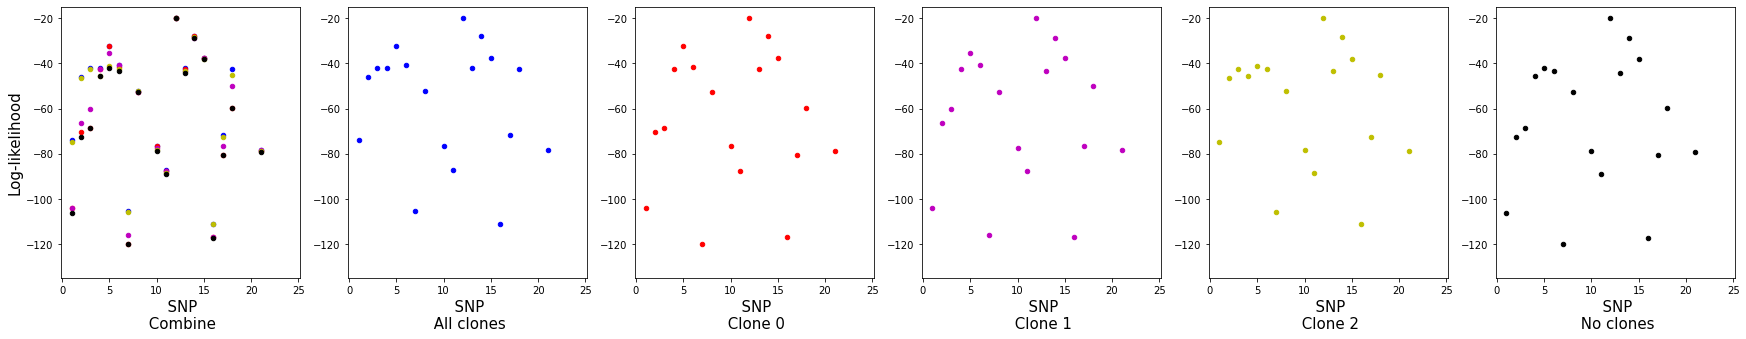

In [68]:
SNPS = np.arange(1, 25, dtype = int)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
ax1.set_xlabel("  SNP \n Combine", fontsize = 15)
ax1.set_ylabel("Log-likelihood", fontsize = 15)
ax2.set_xlabel("  SNP \n All clones", fontsize = 15)
ax3.set_xlabel("  SNP \n Clone 0", fontsize = 15)
ax4.set_xlabel("  SNP \n Clone 1", fontsize = 15)
ax5.set_xlabel("  SNP \n Clone 2", fontsize = 15)
ax6.set_xlabel("  SNP \n No clones", fontsize = 15)
ax1.scatter(SNPS, all_LL, s = 20, c ='b')
ax1.scatter(SNPS, clone0_LL, s = 20, c ='r')
ax1.scatter(SNPS, clone1_LL, s = 20, c ='m')
ax1.scatter(SNPS, clone2_LL, s = 20, c ='y')
ax1.scatter(SNPS, nil_LL, s = 20, c ='k')
ax2.scatter(SNPS, all_LL, s = 20, c ='b')
ax3.scatter(SNPS, clone0_LL, s = 20, c ='r')
ax4.scatter(SNPS, clone1_LL, s = 20, c ='m')
ax5.scatter(SNPS, clone2_LL, s = 20, c ='y')
ax6.scatter(SNPS, nil_LL, s = 20, c ='k')
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax1.get_xlim())
ax6.set_xlim(ax1.get_xlim())
ax1.set_ylim((- 135, - 15))
ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())
ax4.set_ylim(ax1.get_ylim())
ax5.set_ylim(ax1.get_ylim())
ax6.set_ylim(ax1.get_ylim())
plt.show()

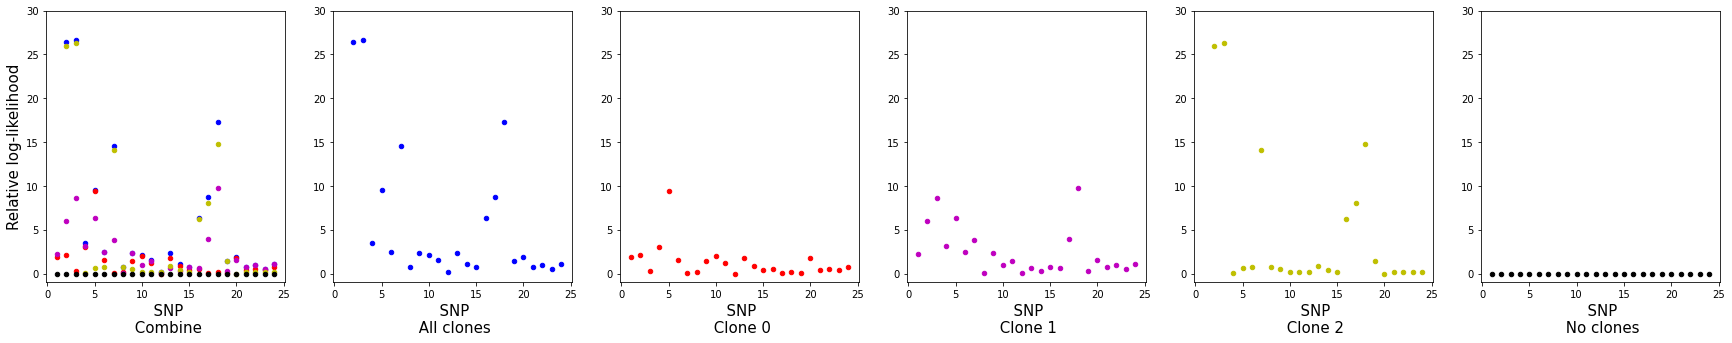

In [69]:
SNPS = np.arange(1, 25, dtype = int)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
ax1.set_xlabel("  SNP \n Combine", fontsize = 15)
ax1.set_ylabel("Relative log-likelihood", fontsize = 15)
ax2.set_xlabel("  SNP \n All clones", fontsize = 15)
ax3.set_xlabel("  SNP \n Clone 0", fontsize = 15)
ax4.set_xlabel("  SNP \n Clone 1", fontsize = 15)
ax5.set_xlabel("  SNP \n Clone 2", fontsize = 15)
ax6.set_xlabel("  SNP \n No clones", fontsize = 15)
ax1.scatter(SNPS, all_LL - nil_LL, s = 20, c ='b')
ax1.scatter(SNPS, clone0_LL - nil_LL, s = 20, c ='r')
ax1.scatter(SNPS, clone1_LL - nil_LL, s = 20, c ='m')
ax1.scatter(SNPS, clone2_LL - nil_LL, s = 20, c ='y')
ax1.scatter(SNPS, nil_LL - nil_LL, s = 20, c ='k')
ax2.scatter(SNPS, all_LL - nil_LL, s = 20, c ='b')
ax3.scatter(SNPS, clone0_LL - nil_LL, s = 20, c ='r')
ax4.scatter(SNPS, clone1_LL - nil_LL, s = 20, c ='m')
ax5.scatter(SNPS, clone2_LL - nil_LL, s = 20, c ='y')
ax6.scatter(SNPS, nil_LL - nil_LL, s = 20, c ='k')
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
ax4.set_xlim(ax1.get_xlim())
ax5.set_xlim(ax1.get_xlim())
ax6.set_xlim(ax1.get_xlim())
ax1.set_ylim((-1, 30))
ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())
ax4.set_ylim(ax1.get_ylim())
ax5.set_ylim(ax1.get_ylim())
ax6.set_ylim(ax1.get_ylim())
plt.show()

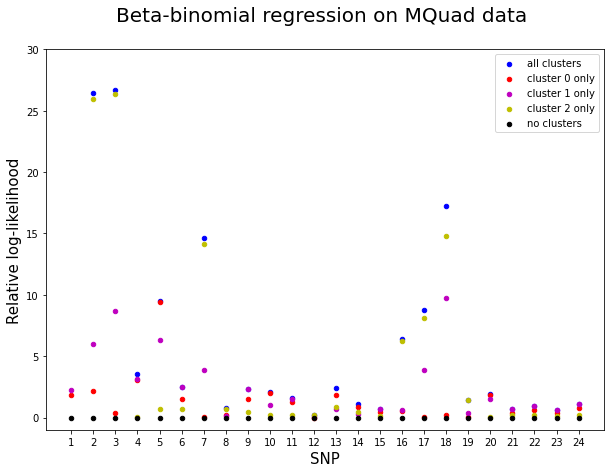

In [70]:
SNPS = np.arange(1, 25, dtype = int)
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
ax1.set_xlabel("SNP", fontsize = 15)
ax1.set_ylabel("Relative log-likelihood", fontsize = 15)
ax1.scatter(SNPS, all_LL - nil_LL, s = 20, c ='b', label = "all clusters")
ax1.scatter(SNPS, clone0_LL - nil_LL, s = 20, c ='r', label = "cluster 0 only")
ax1.scatter(SNPS, clone1_LL - nil_LL, s = 20, c ='m', label = "cluster 1 only")
ax1.scatter(SNPS, clone2_LL - nil_LL, s = 20, c ='y', label = "cluster 2 only")
ax1.scatter(SNPS, nil_LL - nil_LL, s = 20, c ='k', label = "no clusters")
ax1.set_ylim((-1, 30))
ax1.legend()
plt.title("Beta-binomial regression on MQuad data \n", fontsize = 20)
plt.xticks(np.arange(1, 25, 1))
plt.show()